# AIML338, Time Series Analysis
### Lennox Crowe | Assignment 2

https://arxiv.org/pdf/2408.16187

### Task 0: Data exploration (NZEP)
**Objective:** Visualise selected segments of the data to observe and understand its characteristics.
**Output:** A concise analysis of the NZEP dataset to facilitate its use in the remainder of the assignment.

POCs (Point Of Connection): WWD1102, WWD1103


In [188]:
from dataset_generation import get_electricityprice_data
from datetime import date, datetime
import pandas as pd
import pytz

I wrote a function in `dataset_generation.py` which retrieves all data within a date range for a set of PointOfConnection ids. The dataset is cached after it is downloaded once. For this EDA, I am going to focus on the last year of data at the makara wind farm.

In [189]:
df_raw = get_electricityprice_data(start_date = date(2024, 8, 10), end_date = date(2025, 8, 10), poc=["WWD1102", "WWD1103"])

Check that the data has been loaded:

In [190]:
df_raw.head()

,TradingDate,TradingPeriod,PublishDateTime,PointOfConnection,Island,IsProxyPriceFlag,DollarsPerMegawattHour
0,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1102,NI,N,834.55
1,2024-08-10,1,2024-08-10T00:00:00.000+12:00,WWD1103,NI,N,834.55
2,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1102,NI,N,831.84
3,2024-08-10,1,2024-08-10T00:04:42.000+12:00,WWD1103,NI,N,831.84
4,2024-08-10,1,2024-08-10T00:09:33.000+12:00,WWD1102,NI,N,833.55


In [191]:
data_start = df_raw["PublishDateTime"].min()
data_end = df_raw["PublishDateTime"].max()

print("Minimum timestamp: " + str(data_start))
print("Maximum timestamp: " + str(data_end))

Minimum timestamp: 2024-08-10T00:00:00.000+12:00
Maximum timestamp: 2025-08-10T23:54:31.000+12:00


The publish date time will need to be converted to a datetime object.

In [192]:
df_raw["time"] = (pd.to_datetime(df_raw["PublishDateTime"], utc=True))

In [193]:
import matplotlib.pyplot as plt

In [194]:
df_makara_1 = df_raw[df_raw["PointOfConnection"] == "WWD1102"]
df_makara_2 = df_raw[df_raw["PointOfConnection"] == "WWD1103"]

### Check the pricing data and compare the two Point of Connections

Plot the entire time series to check for outliers, seasonality etc.

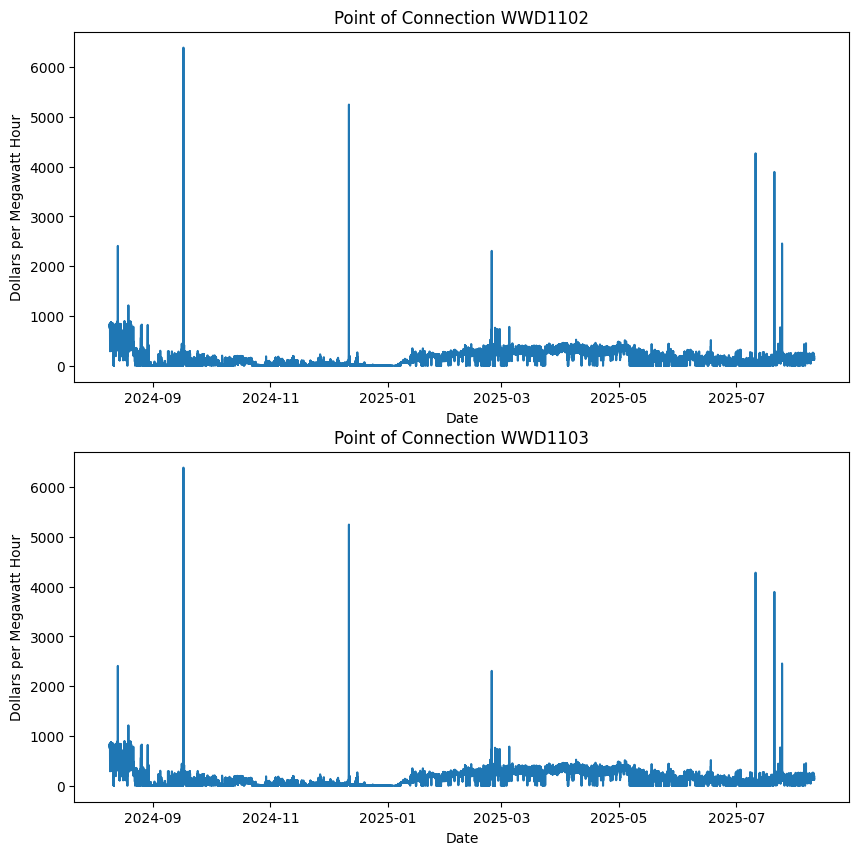

In [225]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].plot(df_makara_1["time"], df_makara_1["DollarsPerMegawattHour"])
axes[0].set_title("Point of Connection WWD1102")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Dollars per Megawatt Hour")

axes[1].plot(df_makara_2["time"], df_makara_2["DollarsPerMegawattHour"])
axes[1].set_title("Point of Connection WWD1103")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Dollars per Megawatt Hour")

plt.show()

It appears that both connection points have the same pricing information, so we will continue the analysis looking at just WWD1102.

## Feature Engineering

Wind data has been obtained from NIWA: https://data.niwa.co.nz/products/climate-station-hourly/map?bounds=172.16674804687503%2C-42.5854442573849%2C177.791748046875%2C-40.21244071828647

This is from Baring head - the closest weather station with wind data for the required time period. It is worth noting that baring head is at sea level, and on the other side of the wellington harbour compared to the wind farm. However, it can be assumed that there is strong correlation between windspeed at Baring head, and wind speed at Makara.

Wind speed may affect wholesale energy price at Makara, as increased windspeed will result in higher energy supply.

I also downloaded a rainfall dataset from NIWA, recorded at Mt Cook village. This will have an impact on the hydro-lake levels, which are one of the major energy sources in New Zealand

In [195]:
wind_df = pd.read_csv("./data/wind.csv")
rain_df = pd.read_csv("./data/rain.csv")

In [196]:
wind_df.head()

,Frequency [D/H],Observation time UTC,Data Source,Direction [deg T],PERIOD [hrs],Speed [m/s]
0,H,1991-03-28T03:00:00Z,H,355.0,1.0,10.9
1,H,1991-03-28T04:00:00Z,H,2.0,1.0,10.2
2,H,1991-03-28T05:00:00Z,H,357.0,1.0,10.4
3,H,1991-03-28T06:00:00Z,H,8.0,1.0,9.3
4,H,1991-03-28T07:00:00Z,H,13.0,1.0,9.1


In [197]:
rain_df.head()

,Frequency [D/H],Observation time UTC,Data Source (rainfall),Rainfall [mm],PERIOD [hrs],Deficit [mm],Runoff [mm],Data source (water balance)
0,S,2016-03-02T05:00:00Z,S,0.0,6,NaN,NaN,NaN
1,S,2016-03-02T11:00:00Z,S,0.0,6,NaN,NaN,NaN
2,S,2016-03-02T17:00:00Z,S,0.0,6,NaN,NaN,NaN
3,S,2016-03-02T23:00:00Z,S,0.0,6,NaN,NaN,NaN
4,S,2016-03-03T05:00:00Z,S,0.0,6,NaN,NaN,NaN


In [198]:
rain_df["Observation time UTC"] = pd.to_datetime(rain_df["Observation time UTC"])
wind_df["Observation time UTC"] = pd.to_datetime(wind_df["Observation time UTC"])

In [199]:
rain_df["Observation Start"] = rain_df["Observation time UTC"].shift(1)
wind_df["Observation Start"] = wind_df["Observation time UTC"].shift(1)

In [200]:
rain_df_filter = rain_df[rain_df['Frequency [D/H]'] == "S"] # this appears to be collected every six hours, at 5am/pm and 11am/pm
wind_df_filter = wind_df[wind_df['Frequency [D/H]'] == "H"]

In [201]:
wind_df_filter.head()

,Frequency [D/H],Observation time UTC,Data Source,Direction [deg T],PERIOD [hrs],Speed [m/s],Observation Start
0,H,1991-03-28 03:00:00+00:00,H,355.0,1.0,10.9,NaT
1,H,1991-03-28 04:00:00+00:00,H,2.0,1.0,10.2,1991-03-28 03:00:00+00:00
2,H,1991-03-28 05:00:00+00:00,H,357.0,1.0,10.4,1991-03-28 04:00:00+00:00
3,H,1991-03-28 06:00:00+00:00,H,8.0,1.0,9.3,1991-03-28 05:00:00+00:00
4,H,1991-03-28 07:00:00+00:00,H,13.0,1.0,9.1,1991-03-28 06:00:00+00:00


In [202]:
rain_df_filter.head()

,Frequency [D/H],Observation time UTC,Data Source (rainfall),Rainfall [mm],PERIOD [hrs],Deficit [mm],Runoff [mm],Data source (water balance),Observation Start
0,S,2016-03-02 05:00:00+00:00,S,0.0,6,NaN,NaN,NaN,NaT
1,S,2016-03-02 11:00:00+00:00,S,0.0,6,NaN,NaN,NaN,2016-03-02 05:00:00+00:00
2,S,2016-03-02 17:00:00+00:00,S,0.0,6,NaN,NaN,NaN,2016-03-02 11:00:00+00:00
3,S,2016-03-02 23:00:00+00:00,S,0.0,6,NaN,NaN,NaN,2016-03-02 17:00:00+00:00
4,S,2016-03-03 05:00:00+00:00,S,0.0,6,NaN,NaN,NaN,2016-03-02 23:00:00+00:00


I am going to compute a column "rolling cumulative rainfall past 6 months" for the rainfall dataset, to represent the previous rainfall conditions.

In [203]:
rain_df_filter["Cumulative Rainfall"] = rain_df_filter["Rainfall [mm]"].rolling(window=4*7*21).sum()

In [204]:
rain_df_filter = rain_df_filter[["Observation time UTC", "Observation Start", "Rainfall [mm]", "Cumulative Rainfall"]]
wind_df_filter = wind_df_filter[["Observation time UTC", "Observation Start", "Speed [m/s]"]]

In [205]:
wind_na_rm = wind_df_filter.dropna()
rain_na_rm = rain_df_filter.dropna()

In [206]:
rain_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Rainfall [mm]": "rain", "Cumulative Rainfall": "rain_cumulative"}, axis=1, inplace=True)
wind_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Speed [m/s]": "speed"}, axis=1, inplace=True)

C:\Users\lenno\AppData\Local\Temp\ipykernel_13652\3030993979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Rainfall [mm]": "rain", "Cumulative Rainfall": "rain_cumulative"}, axis=1, inplace=True)
C:\Users\lenno\AppData\Local\Temp\ipykernel_13652\3030993979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_na_rm.rename({"Observation time UTC": "end", "Observation Start": "start", "Speed [m/s]": "speed"}, axis=1, inplace=True)


In [207]:
rain_na_rm.head()

,end,start,rain,rain_cumulative
587,2016-07-30 06:00:00+00:00,2016-07-30 00:00:00+00:00,6.0,1251.8
588,2016-07-30 12:00:00+00:00,2016-07-30 06:00:00+00:00,0.0,1251.8
589,2016-07-30 18:00:00+00:00,2016-07-30 12:00:00+00:00,0.0,1251.8
590,2016-07-31 00:00:00+00:00,2016-07-30 18:00:00+00:00,0.0,1251.8
591,2016-07-31 06:00:00+00:00,2016-07-31 00:00:00+00:00,0.0,1251.8


In [208]:
data_start

'2024-08-10T00:00:00.000+12:00'

In [209]:
datetime_format = "%Y-%m-%dT%H:%M:%S.%f%z"

In [210]:
# filter the datasets to a time series which matches the energy dataset

rain_final = rain_na_rm[
    (rain_na_rm["start"] >= datetime.fromisoformat(data_start)) &
    (rain_na_rm["end"]   <= datetime.fromisoformat(data_end))
]

wind_final = wind_na_rm[
    (wind_na_rm["start"] >= datetime.fromisoformat(data_start)) &
    (wind_na_rm["end"]   <= datetime.fromisoformat(data_end))
]

In [211]:
wind_final.head()

,end,start,speed
282483,2024-08-09 13:00:00+00:00,2024-08-09 12:00:00+00:00,14.3
282484,2024-08-09 14:00:00+00:00,2024-08-09 13:00:00+00:00,14.0
282485,2024-08-09 15:00:00+00:00,2024-08-09 14:00:00+00:00,13.4
282486,2024-08-09 16:00:00+00:00,2024-08-09 15:00:00+00:00,12.2
282487,2024-08-09 17:00:00+00:00,2024-08-09 16:00:00+00:00,12.0


In [212]:
df_points = df_makara_1[["TradingPeriod", "DollarsPerMegawattHour", "time"]].copy()
df_points["time"] = pd.to_datetime(df_points["time"], utc=True)
df_points = df_points.sort_values("time")

rain_intervals = rain_final[["start", "end", "rain", "rain_cumulative"]].copy()
rain_intervals["start"] = pd.to_datetime(rain_intervals["start"], utc=True)
rain_intervals["end"]   = pd.to_datetime(rain_intervals["end"], utc=True)
rain_intervals = rain_intervals.sort_values("start")

wind_intervals = wind_final[["start", "end", "speed"]].copy()
wind_intervals["start"] = pd.to_datetime(wind_intervals["start"], utc=True)
wind_intervals["end"]   = pd.to_datetime(wind_intervals["end"], utc=True)
wind_intervals = wind_intervals.sort_values("start")

# Merge rain using merge_asof (nearest previous start)
df_points_rain = pd.merge_asof(
    df_points,
    rain_intervals,
    left_on="time",
    right_on="start",
    direction="backward",
)

# Keep only points within interval
df_points_rain = df_points_rain[df_points_rain["time"] <= df_points_rain["end"]].copy()

# Merge wind similarly
df_final = pd.merge_asof(
    df_points_rain.sort_values("time"),
    wind_intervals.sort_values("start"),
    left_on="time",
    right_on="start",
    direction="backward",
    suffixes=('_rain', '_wind')
)


In [213]:
len(df_final)

104374

In [224]:
df_final.head()

,TradingPeriod,DollarsPerMegawattHour,time,start_rain,end_rain,rain,rain_cumulative,start_wind,end_wind,speed
0,1,834.55,2024-08-09 12:00:00+00:00,2024-08-09 12:00:00+00:00,2024-08-09 18:00:00+00:00,0.0,704.2,2024-08-09 12:00:00+00:00,2024-08-09 13:00:00+00:00,14.3
1,1,831.84,2024-08-09 12:04:42+00:00,2024-08-09 12:00:00+00:00,2024-08-09 18:00:00+00:00,0.0,704.2,2024-08-09 12:00:00+00:00,2024-08-09 13:00:00+00:00,14.3
2,1,833.55,2024-08-09 12:09:33+00:00,2024-08-09 12:00:00+00:00,2024-08-09 18:00:00+00:00,0.0,704.2,2024-08-09 12:00:00+00:00,2024-08-09 13:00:00+00:00,14.3
3,1,830.47,2024-08-09 12:14:44+00:00,2024-08-09 12:00:00+00:00,2024-08-09 18:00:00+00:00,0.0,704.2,2024-08-09 12:00:00+00:00,2024-08-09 13:00:00+00:00,14.3
4,1,830.10,2024-08-09 12:19:39+00:00,2024-08-09 12:00:00+00:00,2024-08-09 18:00:00+00:00,0.0,704.2,2024-08-09 12:00:00+00:00,2024-08-09 13:00:00+00:00,14.3


The previous charts didn't show much detail.

In [227]:
df_zoomed = df_final[
      (df_final["time"] >= pd.Timestamp(datetime(2025, 7, 1, tzinfo = pytz.utc)))
    & (df_final["time"] <= pd.Timestamp(datetime(2025, 7, 5, tzinfo = pytz.utc)))
]

Text(0.5, 1.0, 'Five days, WWD1102')

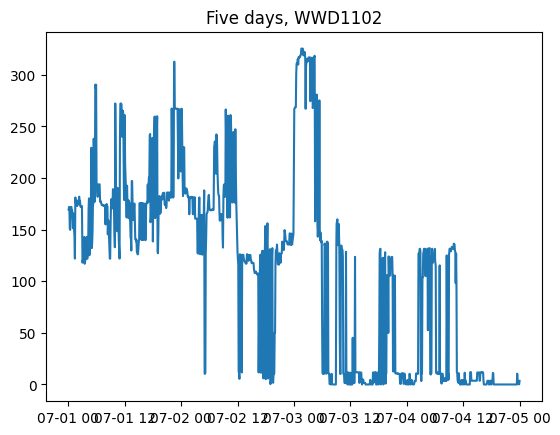

In [230]:
plt.plot(df_zoomed["time"], df_zoomed["DollarsPerMegawattHour"])
plt.title("Five days, WWD1102")

## EDA for Windspeed and Rainfall

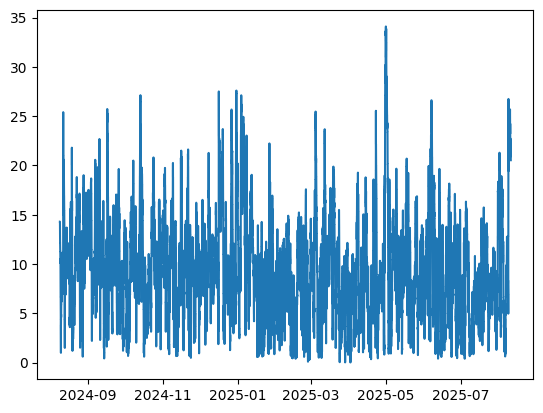

In [226]:
plt.plot(df_final.time, df_final["speed"])

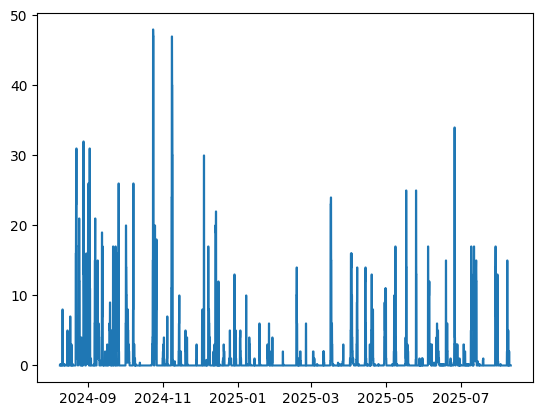

In [231]:
plt.plot(df_final.time, df_final["rain"])

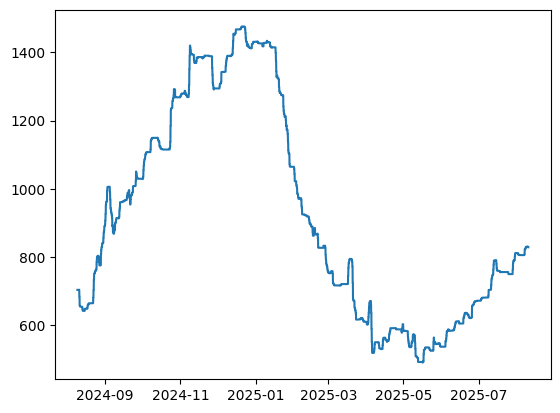

In [232]:
plt.plot(df_final.time, df_final["rain_cumulative"])

## Split into a train and test set

## Cross-validation - TimeSeriesSplit

To avoid data leakage, we should split into train and test sets before doing any more EDA. When dealing with time series data, we cannot train on future observations (otherwise the test accuracy would be biased). SKLearn provides the function `TimeSeriesSplit` to perform a 'rolling window evaluation'. This is essentially time-based cross validation. Rolling window evaluation differs from sliding window evaluation, which increments the training set forward by one observation each window - evaluating every subset of train/test data. This is only appropriate for small datasets as it gets computationally expensive on large datasets.

Strategy:
- Get one years worth of data
- Perform EDA on the first six months
- Do a cross validation TimeSeriesSplit

In actuality, we would rather train on a full years worth of data as this would include information about the previous season in the training data. This is important as the usage of electricity is likely to fluctuate with the seasons. However, there were technical issues extracting data from 2023 from emi. For this exercise, only using six months of training data is okay.

In [274]:
# first six months
df_train = df_final[(df_raw["time"] < df_final["time"].min() + pd.Timedelta(days=180))]

C:\Users\lenno\AppData\Local\Temp\ipykernel_13652\3306711243.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_final[(df_raw["time"] < df_final["time"].min() + pd.Timedelta(days=180))]


This chart of five days worth of pricing data shows that wholesale electricity price is very dynamic, ranging from \\$0 to over \\$300 per MWH. There also isn't a simple seasonal pattern. It is interesting that the price will sometimes go to $0 - I am unsure if this is an error in the dataset, or where electricity is surplus to demand and therefore the price drops to 0.

## Augmented Dickey-Fuller (ADF) test for Stationary time series

An ARIMA model will only work with a stationary time series.

- A stationary time series has constant statistical properties over time.
- The ADF test checks for a unit root. A unit root is characteristic of non-stationary data.
- A 'unit root' would mean that a shock to the series has a permanent effect (i.e. the series would drift over time and not revert to the mean. This is not characteristic of stationary data...).
- A small p-value would indicate a stationary time series.
- To apply an ARIMA model, the time series should be differenced until the time series is stationary.

In [237]:
from statsmodels.tsa.stattools import adfuller

In [238]:
adf_test = adfuller(df_train["DollarsPerMegawattHour"])

In [239]:
# find the p-value
adf_test[1]

np.float64(4.530808810230791e-20)

The p-value is very small, so we can reject the null hypothesis (the series has a unit root) and claim that the time series is stationary without differencing.

# Fitting an ARIMA model

I wanted to define a window which trains using the past six months, and evaluates (and slides by) one month. `TimeSeriesSplit` is not capable of this, so I had to write my own function instead.

This function allows you to define a custom "training length" and "sliding window length".

In [270]:
def time_series_split_middle(df, jump_length="30D", window_size_length="180D", time_col="time"):
    df = df.sort_values(time_col)
    window_size = pd.Timedelta(window_size_length)
    jump_size = pd.Timedelta(jump_length)

    start_time = df[time_col].min() + window_size
    end_time = df[time_col].max()

    splits = []

    while start_time + jump_size <= end_time:
        train_idx = df[(df[time_col] < start_time) & (df[time_col] > start_time - window_size)].index
        test_idx = df[(df[time_col] >= start_time) & (df[time_col] < start_time + jump_size)].index
        if len(test_idx) == 0:
            break
        splits.append((train_idx, test_idx))
        start_time += jump_size
    return splits

def get_data(df, split):
    return df.iloc[split[0]], df.iloc[split[1]]

In [271]:
splits = time_series_split_middle(df_final)

## Part 1: Fit ARIMA

In [275]:
# work on df_train to mitigate data leakage

# to find the parameters for an ARIMA model you must:
